In [1]:
import numpy as np

# from PIL import Image

import torch
import torchvision
from torchvision import transforms


# import agd
from agd import Eikonal
from agd.Metrics import Riemann
from agd.LinearParallel import outer_self as Outer # outer product v v^T of a vector with itself
#from agd.Plotting import savefig, quiver; #savefig.dirName = 'Figures/Riemannian'
#from agd import LinearParallel as lp
# from agd import AutomaticDifferentiation as ad

import time

from sklearn.cluster import AgglomerativeClustering
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt

from utils.OrientationScore import gaussian_OS
from utils.dataset import ULMDataset, IOSTARDataset

from nn.ulm_unet import ULM_UNet

from skimage.filters import frangi

try:
    from utils.transforms import Rescale, RandomCrop, ToTensor, HeatMap, Rescale_image, ColorJitter, GlobalContrastNormalization, RandomAffine, Padding, CenterCrop, ToArray
except:
    from transforms import Rescale, RandomCrop, ToTensor, HeatMap, Rescale_image, ColorJitter, GlobalContrastNormalization, RandomAffine, Padding, CenterCrop, ToArray
    
import networkx as nx

import sys
sys.path.append("./../ULM_data")

./data_IOSTAR/test_images/images_IOSTAR/test_IOSTAR_27.png
hellooooo
['IOSTAR_points_10.mat', 'IOSTAR_points_11.mat', 'IOSTAR_points_12.mat', 'IOSTAR_points_13.mat', 'IOSTAR_points_14.mat', 'IOSTAR_points_15.mat', 'IOSTAR_points_16.mat', 'IOSTAR_points_17.mat', 'IOSTAR_points_18.mat', 'IOSTAR_points_19.mat', 'IOSTAR_points_20.mat', 'IOSTAR_points_26.mat', 'IOSTAR_points_27.mat', 'IOSTAR_points_28.mat', 'IOSTAR_points_29.mat', 'IOSTAR_points_30.mat', 'IOSTAR_points_31.mat', 'IOSTAR_points_6.mat', 'IOSTAR_points_7.mat', 'IOSTAR_points_8.mat', 'IOSTAR_points_9.mat']
['test_IOSTAR_10.png', 'test_IOSTAR_11.png', 'test_IOSTAR_12.png', 'test_IOSTAR_13.png', 'test_IOSTAR_14.png', 'test_IOSTAR_15.png', 'test_IOSTAR_16.png', 'test_IOSTAR_17.png', 'test_IOSTAR_18.png', 'test_IOSTAR_19.png', 'test_IOSTAR_20.png', 'test_IOSTAR_26.png', 'test_IOSTAR_27.png', 'test_IOSTAR_28.png', 'test_IOSTAR_29.png', 'test_IOSTAR_30.png', 'test_IOSTAR_31.png', 'test_IOSTAR_6.png', 'test_IOSTAR_7.png', 'test_IOSTAR_

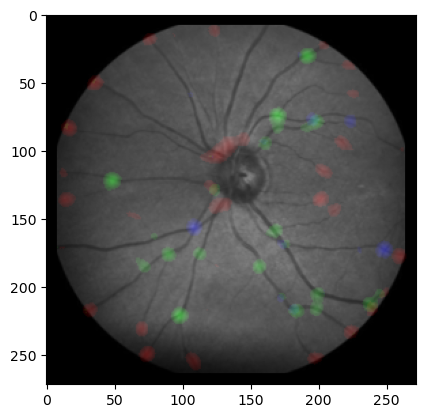

In [7]:
validation_dataset = IOSTARDataset(root_dir =  './data_IOSTAR/test_images', transform=transforms.Compose([Rescale(256), RandomCrop(256), GlobalContrastNormalization(), HeatMap(s=9, alpha=3, out_channels = 4), ToTensor(), Padding(8)])) 
batch = validation_dataset[12]

im_tensor = batch['image'].unsqueeze(0)

model = ULM_UNet(in_channels=3, init_features=64, threshold = 0.15, out_channels = 4)
model.load_state_dict(torch.load('./weights/ulm_net_IOSTAR_epochs_1000_size_256_batch_4_out_channels_4_alpha_3.555774513043065_18_9_NoEndpoints_0.pt'))
Nt = 64

output = model(im_tensor)

plt.figure(0)
plt.imshow(im_tensor[0,0,:,:].detach().numpy(), cmap = 'gray')
plt.imshow((output[0,:-1,:,:].permute([1,2,0]).detach().numpy())*((output[0,:-1,:,:].permute([1,2,0]).detach().numpy()>0.15)+0.), cmap = 'jet', alpha = 0.5)

/tmp/ipykernel_1433653/1573632077.py:7: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  frangi_lambda = lambda x: frangi(x, beta=param_beta, scale_range=scale, scale_step=step, alpha=param_alpha)


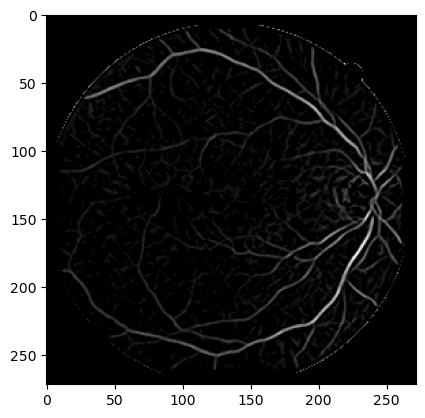

In [3]:
param_beta = .5
param_alpha = 0.5
im_tensor=im_tensor.squeeze()
scale = (.01,1)
step = 0.01

frangi_lambda = lambda x: frangi(x, beta=param_beta, scale_range=scale, scale_step=step, alpha=param_alpha)

A = np.array([frangi_lambda(im_tensor[0].numpy()), frangi_lambda(im_tensor[1].numpy()), frangi_lambda(im_tensor[2].numpy())])*(im_tensor.mean(dim=0)>0.15).numpy()
A = torch.tensor(A/A.max(axis=(1,2), keepdims=True)).max(dim=0).values**0.5

plt.imshow(A, cmap = 'gray',vmin=0.,vmax=1.)

/home/tbertrand/anaconda3/envs/ULM_landmark/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484747997/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0.15878366


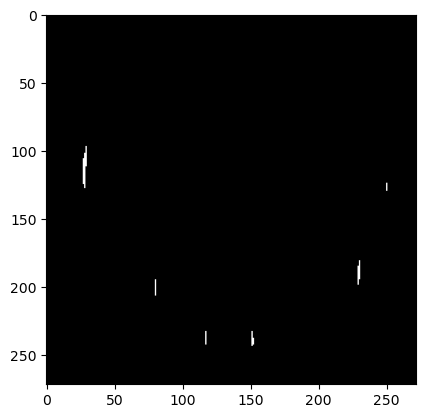

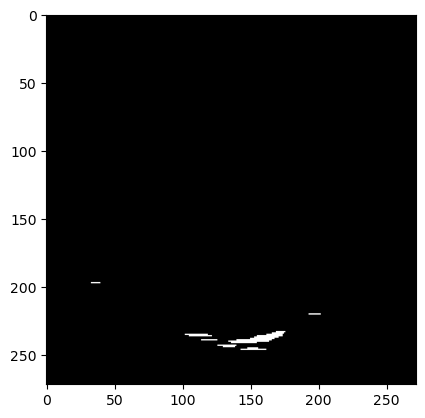

In [4]:
lifted_im_array = gaussian_OS(A.T, sigma = 0.001, eps = 0.1, N_o = Nt)

print((lifted_im_array[...,0]*lifted_im_array[...,32]).mean()/(lifted_im_array.max(axis=2)**2).mean())

plt.figure(0)
plt.imshow(lifted_im_array[...,0]>0.2, cmap = 'gray',vmin=0.,vmax=1.)

plt.figure(1)
plt.imshow(lifted_im_array[...,32]>0.2, cmap = 'gray',vmin=0.,vmax=1.)

torch.Size([124, 3])


/tmp/ipykernel_1433653/3978961129.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_tensor = torch.tensor(points).long()


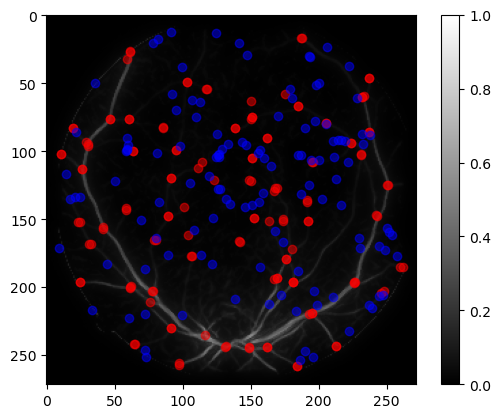

In [5]:
plt.imshow((lifted_im_array/((lifted_im_array>0.2 + 0.)*lifted_im_array.max(axis=2, keepdims=True) + (1.-(lifted_im_array>0.2+0.)))).mean(axis=2), cmap='gray', vmin=0., vmax=1.)
plt.colorbar()

W = (lifted_im_array/((lifted_im_array>0.2 + 0.)*lifted_im_array.max(axis=2, keepdims=True) + (1.-(lifted_im_array>0.2+0.)))).mean(axis=2).T


from HFM_computations import Modify_Metric_and_Points, Detection_Model, Show_Curves

points_th = batch['landmarks']
points_th = points_th[points_th[:,0]>0]
print(points_th.shape)

points = Detection_Model(model, batch, threshold=0.15)

points_tensor = torch.tensor(points).long()

plt.scatter(points_tensor[:,0], points_tensor[:,1], c='r', alpha=0.5)
plt.scatter(points_th[:,1], points_th[:,0], c='b', alpha=0.5)  

theta_indices = torch.tensor(lifted_im_array)[[points_tensor[:,1],points_tensor[:,0]]].argmax(dim=1)

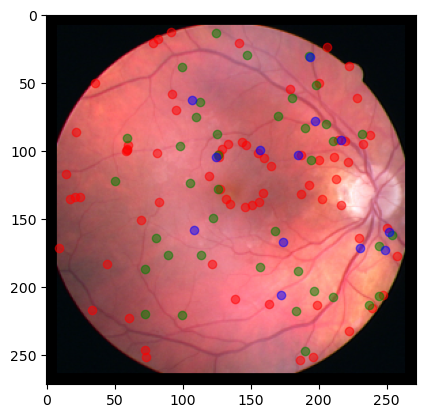

In [6]:
plt.imshow(im_tensor.permute([1,2,0]), cmap='gray')
plt.scatter(points_th[:,1][points_th[:,2]==0], points_th[:,0][points_th[:,2]==0], c='r', alpha=0.5)  
plt.scatter(points_th[:,1][points_th[:,2]==1], points_th[:,0][points_th[:,2]==1], c='g', alpha=0.5)  
plt.scatter(points_th[:,1][points_th[:,2]==2], points_th[:,0][points_th[:,2]==2], c='b', alpha=0.5)  

